In [31]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.spatial import distance

In [199]:
def load_initial(name):
    nodes = np.loadtxt(f"TSP/{name}.tsp.txt", skiprows = 6, max_rows = 51)
    opt_tour = np.loadtxt(f"TSP/{name}.opt.tour.txt", skiprows = 5, max_rows = 51)

    d_nodes = {}
    for node in nodes: 
        d_nodes[node[0]] = (node[1], node[2])

    return d_nodes, opt_tour

def plotnodes(nodes): 
    plt.figure(figsize = (9,9))
    for node, coordinates in nodes.items():
        plt.plot(coordinates[0], coordinates[1], 'ro')
        plt.annotate(int(node), (coordinates[0], coordinates[1]))

def plotedges(d_nodes, tour): 

    for i, node in enumerate(tour):
        
        if i >= len(tour) - 1: 

            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]

        x_coords = [x1,x2]
        y_coords = [y1,y2]

        plt.plot(x_coords, y_coords, color = 'grey')

def tour_length(d_nodes, tour):
    total_length_manual = 0

    for i, node in enumerate(tour):
        if i >= len(tour) - 1: 
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]
       
        length_manual = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
        
        total_length_manual += length_manual
    return total_length_manual

length = 429.98331198338406


<Figure size 1080x648 with 0 Axes>

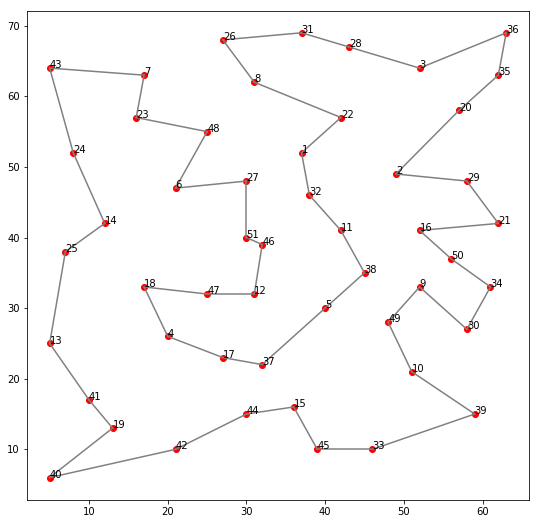

In [200]:
initial = load_initial("eil51")
plt.figure(figsize = (15,9))
plotnodes(initial[0])
plotedges(initial[0], initial[1])
print('length = ' + str(tour_length(initial[0], initial[1])))

In [201]:
def make_d_nodes(nodes): 
    
    d_nodes = {}
    for node in nodes: 
        d_nodes[node[0]] = (node[1], node[2])

def make_tour_edges(tour): 
    tour_edges = []

    for i, node in enumerate(tour):
        if i < len(opt_tour) - 1: 
            tour_edges.append([node, tour[i+1]])
        else:
            tour_edges.append([node, tour[0]])
    
    return tour_edges

def make_distance_matrix(d_nodes, n_nodes):
        
    distance_matrix = np.zeros((n_nodes,n_nodes))
    for node1 in range(n_nodes):
        for node2 in range(n_nodes): 
            
            x1 = d_nodes[node1+1][0]
            x2 = d_nodes[node2+1][0]
            y1 = d_nodes[node1+1][1]
            y2 = d_nodes[node2+1][1]
            distance_matrix[node1, node2] = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
    
    return distance_matrix
    
def comp_length_from_matrix(tour, distance_matrix):

    tour_edges = make_tour_edges(tour)
    total_distance = 0
    for edge in tour_edges: 
        total_distance += distance_matrix[int((edge[0] - 1)), int((edge[1] - 1))]
    return total_distance

def make_random_route(n_nodes):
    l_nodes = np.arange(1,n_nodes+1)
    return list(np.random.permutation(l_nodes))

<Figure size 1080x648 with 0 Axes>

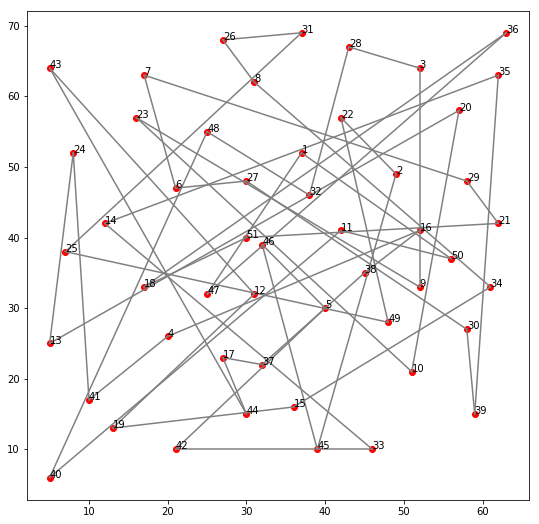

Length of tour = 1514.529521232749


In [202]:
n_nodes = 51
distance_matrixeil51 = make_distance_matrix(d_nodes, 51)

random_route = make_random_route(51)

plt.figure(figsize = (15,9))
plotnodes(initial[0])
plotedges(initial[0], random_route)
plt.show()

print(f'Length of tour = {comp_length_from_matrix(random_route, distance_matrixeil51)}')

tour = [2, 3, 6, 1, 5, 4]

In [203]:
def lin2opt(tour): 
    n_nodes = len(tour)
    rand_node1 = np.random.random_integers(1, n_nodes)
    rand_node2 = np.random.random_integers(1, n_nodes)


    i_rand_node1 = np.argwhere(tour == rand_node1)[0][0]
    i_rand_node2 = np.argwhere(tour == rand_node2)[0][0]

    subtour = tour[min(i_rand_node1, i_rand_node2) + 1 : max(i_rand_node1, i_rand_node2)]

    subtour.reverse()

    tour[min(i_rand_node1, i_rand_node2) + 1 : max(i_rand_node1, i_rand_node2)] = subtour
    
    return tour

In [227]:
def simulated_annealing(nodes, initial_tour, markov_length, initial_temp, cool_rate):
    tour = initial_tour
    temp = initial_temp

    # for plotting the costs per iteration
    costs = []

    for i in range(markov_length):
        # progress update
        if i % 1000 == 0:
            print('\r', f"{i} out of {markov_length}", end='')

        costs.append(tour_length(nodes, tour[:]))
        new_tour = lin2opt(tour[:])
        accept_prob = math.exp(min(709, -(tour_length(nodes, new_tour) - costs[-1])/temp))

        if accept_prob >= 1 or np.random.rand() <= accept_prob:
            tour = new_tour

        temp *= cool_rate

    plt.plot(range(markov_length), costs)
    plt.show()

    return tour

 0 out of 50000

C:\Users\sande\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 51 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sande\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 51 + 1) instead
  after removing the cwd from sys.path.


 49000 out of 50000

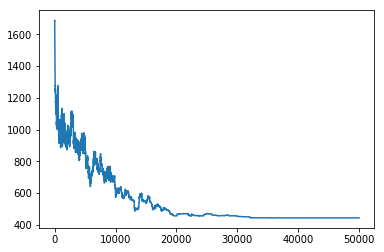

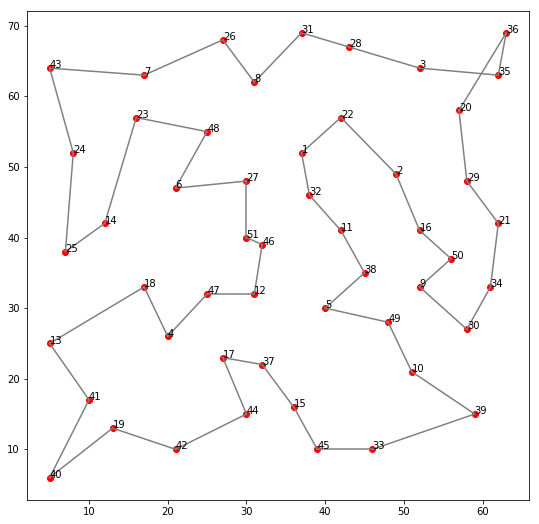

In [228]:
nodes = load_initial("eil51")[0]
annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), 50000, 15, 0.9999)
plotnodes(nodes)
plotedges(nodes, annealed_tour)